# Optimization Algorithms

优化算法  
凸优化问题：函数的 hessian 矩阵的特征值非负（0 或 正）

## 凸优化问题

### Convexity  凸性  
凸性在优化算法的设计中起着至关重要的作用。这主要是因为在这样的背景下分析测试算法要容易得多。  
换句话说，如果算法在凸性设置下表现不佳，通常我们不应该期望在其他情况下看到很好的结果。  
此外，尽管深度学习中的优化问题通常是非凸的，但它们在局部最小值附近往往表现出一些凸问题的性质。这可能导致诸如（Izmailov 等人，2018 年）所提出的新颖的优化变体。

### 凸集 与 凸函数性质

1. 凸集的交集依然是凸集  凸集的并集不一定是凸集   
凸函数： $ \lambda f(x) + (1-\lambda) f(x') \geq f(\lambda x + (1-\lambda) x'). $  
2. 凸函数的局部最小值即全局最小值  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202409242045097.png" width='700px' >
</div>  

3. Jensen 不等式  
$ \sum_i \alpha_i f(x_i)  \geq f\left(\sum_i \alpha_i x_i\right)    \textrm{ and }    E_X[f(X)]  \geq f\left(E_X[X]\right),$   
基于此可以推导出变分推断的性质 $ E_{Y \sim P(Y)}[-\log P(X \mid Y)] \geq -\log P(X), $  

4. 凸函数的局部最小值就是全局最小值

5. 一个可两次求导的函数是凸函数，**当且仅当**其 Hessian（二阶导数的矩阵）是正半定矩阵：  
形式上，一个一维的两次可微函数 f:R→R 是凸的，当且仅当其二阶导数 f″≥0 。  
对于任何两次可微的多维函数 f:Rn→R ，它是凸的，当且仅当其 Hessian ∇2f⪰0 。

6. **凸约束**可以通过拉格朗日乘子添加。在实践中，我们可能只需将它们作为惩罚项添加到目标函数中  

7. 投影映射到与原始点最近的凸集内的点。  
<div style="text-align: center;">
  <img src="https://cdn.jsdelivr.net/gh/Huangl19/imgbed/202409250931587.png" width='400px' >
</div>  

## 梯度下降

In [1]:
%matplotlib inline
import numpy as np
import torch
import dl2_torch as d2l
import math
import torch.nn as nn

d:\Anaconda3\envs\data_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:

def f(x):  # Objective function
    return x ** 2

def f_grad(x):  # Gradient (derivative) of the objective function
    return 2 * x

d:\Anaconda3\envs\data_torch\lib\site-packages\tqdm\auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [6]:
def gd(eta, f_grad):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x)
        results.append(float(x))
    print(f'epoch 10, x: {x:f}')
    return results

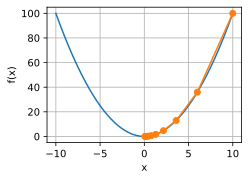

In [4]:
def show_trace(results, f):
    n = max(abs(min(results)), abs(max(results)))
    f_line = torch.arange(-n, n, 0.01)
    d2l.set_figsize()
    d2l.plot([f_line, results], [[f(x) for x in f_line], [
        f(x) for x in results]], 'x', 'f(x)', fmts=['-', '-o'])

当学习率设置过大时，梯度下降会逐渐发散，如下所示。  
从泰勒展开角度看  $f(x - \eta f'(x)) = f(x) - \eta f'^2(x) + \mathcal{O}(\eta^2 f'^2(x))$  发散是由于学习率过大，使得皮亚诺余项不可忽略，从而$f(x - \eta f'(x))$ 没有减小

epoch 10, x: 61.917364


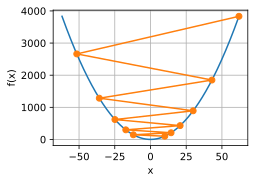

In [5]:
show_trace(gd(1.1, f_grad), f)

### 牛顿法

$ f(\mathbf{x} + \boldsymbol{\epsilon}) = f(\mathbf{x}) + \boldsymbol{\epsilon}^\top \nabla f(\mathbf{x}) + \frac{1}{2} \boldsymbol{\epsilon}^\top \nabla^2 f(\mathbf{x}) \boldsymbol{\epsilon} + \mathcal{O}(\|\boldsymbol{\epsilon}\|^3). $  
令 $\mathbf{H} \stackrel{\textrm{def}}{=} \nabla^2 f(\mathbf{x})$ ,对上式关于 $\boldsymbol{\epsilon}$ 进行求导（即在初始值x确定的条件下求变量使得 $f(\mathbf{x} + \boldsymbol{\epsilon})$ 最小）  
求得 $\nabla f(\mathbf{x}) + \mathbf{H} \boldsymbol{\epsilon} = 0 \textrm{ and hence }
\boldsymbol{\epsilon} = -\mathbf{H}^{-1} \nabla f(\mathbf{x}).$   即通过计算 $\mathbf{H}^{-1}$ ，可以在x的条件下直接找到最小值。

作为一个简单的例子，对于$ f(x) = \frac{1}{2} x^2$ 我们有 ∇f(x)=x 和 H=1 。因此，对于任何 x 我们得到 ϵ=−x 。换句话说，只需一步就能完美收敛，无需任何调整！遗憾的是，我们在这里有点幸运：泰勒展开式在这里是精确的，因为 $f(x+\epsilon)= \frac{1}{2} x^2 + \epsilon x + \frac{1}{2} \epsilon^2$   
现在让我们考虑一个非凸函数，例如对于某个常数 c ，有 f(x)=xcos⁡(cx) 。毕竟，请注意在牛顿法中，我们最终会除以海森矩阵。这意味着如果二阶导数是负的，我们可能会走向增加 f 值的方向。这是算法的一个致命缺陷。让我们看看在实践中会发生什么。

In [7]:
c = torch.tensor(0.5)

def f(x):  # Objective function
    return torch.cosh(c * x)

def f_grad(x):  # Gradient of the objective function
    return c * torch.sinh(c * x)

def f_hess(x):  # Hessian of the objective function
    return c**2 * torch.cosh(c * x)

def newton(eta=1):
    x = 10.0
    results = [x]
    for i in range(10):
        x -= eta * f_grad(x) / f_hess(x)
        results.append(float(x))
    print('epoch 10, x:', x)
    return results

epoch 10, x: tensor(26.8341)


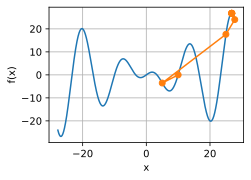

In [8]:
c = torch.tensor(0.15 * np.pi)

def f(x):  # Objective function
    return x * torch.cos(c * x)

def f_grad(x):  # Gradient of the objective function
    return torch.cos(c * x) - c * x * torch.sin(c * x)

def f_hess(x):  # Hessian of the objective function
    return - 2 * c * torch.sin(c * x) - x * c**2 * torch.cos(c * x)

show_trace(newton(), f)

 [牛顿法收敛速度](https://d2l.ai/chapter_optimization/gd.html#one-dimensional-gradient-descent) :$\left|e^{(k+1)}\right| \leq c (e^{(k)})^2.$ 算法以线性收敛速度收敛  
 预处理牛顿法（预条件处理有助于调整尺度）：  $\mathbf{x} \leftarrow \mathbf{x} - \eta \textrm{diag}(\mathbf{H})^{-1} \nabla f(\mathbf{x})$  即仅计算hessian矩阵对角矩阵的逆矩阵，实现对不同量纲大小的自变量采用不同大小的优化速率

## SGD

对于凸问题，我们可以证明对于广泛选择的学习率，随机梯度下降将收敛到最优解。  
对于深度学习来说，通常并非如此。然而对凸问题的分析使我们能够对如何进行优化获得有用的见解，即逐步降低学习率，尽管不是太快。  


随机梯度演示示例

epoch 50, x1: 0.189146, x2: -0.092075


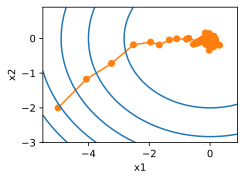

In [3]:
def f(x1, x2):  # Objective function
    return x1 ** 2 + 2 * x2 ** 2

def f_grad(x1, x2):  # Gradient of the objective function
    return 2 * x1, 4 * x2

def sgd(x1, x2, s1, s2, f_grad):
    g1, g2 = f_grad(x1, x2)
    # Simulate noisy gradient
    g1 += torch.normal(0.0, 1, (1,)).item()
    g2 += torch.normal(0.0, 1, (1,)).item()
    eta_t = eta * lr()
    return (x1 - eta_t * g1, x2 - eta_t * g2, 0, 0)

def constant_lr():
    return 1

eta = 0.1
lr = constant_lr  # Constant learning rate
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

动态学习率  
$$ \begin{split}\begin{aligned}
    \eta(t) & = \eta_i \textrm{ if } t_i \leq t \leq t_{i+1}  && \textrm{piecewise constant} \\
    \eta(t) & = \eta_0 \cdot e^{-\lambda t} && \textrm{exponential decay} \\
    \eta(t) & = \eta_0 \cdot (\beta t + 1)^{-\alpha} && \textrm{polynomial decay}
\end{aligned}\end{split}   $$  
指数衰减降低幅度过快效果不佳 ，α = 0.5的多项式衰减在凸优化的情况下，有多个证明表明这种速率表现良好。

epoch 1000, x1: -0.984035, x2: -0.007597


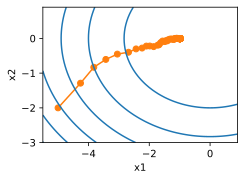

In [8]:
#  指数学习率
def exponential_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return math.exp(-0.1 * t)

t = 1
lr = exponential_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=1000, f_grad=f_grad))

epoch 50, x1: 0.018060, x2: 0.126729


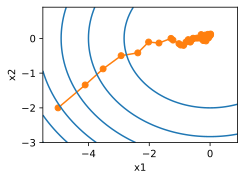

In [7]:
#  多项式学习率
def polynomial_lr():
    # Global variable that is defined outside this function and updated inside
    global t
    t += 1
    return (1 + 0.1 * t) ** (-0.5)

t = 1
lr = polynomial_lr
d2l.show_trace_2d(f, d2l.train_2d(sgd, steps=50, f_grad=f_grad))

## Minibatch SGD

In [20]:
from time import sleep

In [22]:
def train_concise_ch11(trainer_fn, hyperparams, data_iter, num_epochs=4):
    # Initialization
    net = nn.Sequential(nn.Linear(5, 1))
    def init_weights(module):
        if type(module) == nn.Linear:
            torch.nn.init.normal_(module.weight, std=0.01)
    net.apply(init_weights)

    optimizer = trainer_fn(net.parameters(), **hyperparams)
    loss = nn.MSELoss(reduction='none')
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            print(n)
            optimizer.zero_grad()
            out = net(X)
            y = y.reshape(out.shape)
            l = loss(out, y)
            l.mean().backward()
            optimizer.step()
            n += X.shape[0]
            if n % 100 == 0:
                timer.stop()
                # `MSELoss` computes squared error without the 1/2 factor
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss) / 2,))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')

#### 测试不同 batchsize 大小的训练效果及效率

loss: 0.243, 0.061 sec/epoch


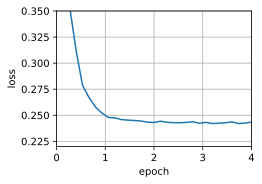

In [8]:
data_iter, _ = d2l.get_data_ch11(10)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter)

loss: 0.448, 0.016 sec/epoch


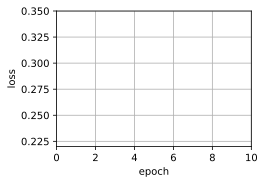

In [26]:
data_iter, _ = d2l.get_data_ch11(1500)
trainer = torch.optim.SGD
train_concise_ch11(trainer, {'lr': 0.01}, data_iter, num_epochs=10)

从loss变换的结果来看， 当batch_size = 10的时候训练loss下降最快， 全量梯度下降效果反而不佳。  

In [31]:
#  梯度下降
def sgd(params, states, hyperparams):
    for p in params:
        p.data.sub_(hyperparams['lr'] * p.grad)
        p.grad.data.zero_()

In [28]:
#@save
def train_ch11(trainer_fn, states, hyperparams, data_iter,
               feature_dim, num_epochs=2):
    # Initialization
    w = torch.normal(mean=0.0, std=0.01, size=(feature_dim, 1),
                     requires_grad=True)
    b = torch.zeros((1), requires_grad=True)
    net, loss = lambda X: d2l.linreg(X, w, b), d2l.squared_loss
    # Train
    animator = d2l.Animator(xlabel='epoch', ylabel='loss',
                            xlim=[0, num_epochs], ylim=[0.22, 0.35])
    n, timer = 0, d2l.Timer()
    for _ in range(num_epochs):
        for X, y in data_iter:
            l = loss(net(X), y).mean()
            l.backward()
            trainer_fn([w, b], states, hyperparams)
            n += X.shape[0]
            if n % 200 == 0:
                timer.stop()
                animator.add(n/X.shape[0]/len(data_iter),
                             (d2l.evaluate_loss(net, data_iter, loss),))
                timer.start()
    print(f'loss: {animator.Y[0][-1]:.3f}, {timer.sum()/num_epochs:.3f} sec/epoch')
    return timer.cumsum(), animator.Y[0]

loss: 0.242, 0.010 sec/epoch


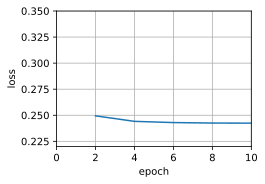

In [30]:
def train_sgd(lr, batch_size, num_epochs=2):
    data_iter, feature_dim = d2l.get_data_ch11(batch_size)
    return train_ch11(
        sgd, None, {'lr': lr}, data_iter, feature_dim, num_epochs)

gd_res = train_sgd(1, 1500, 10)

同样是全量梯度下降，收敛效果比系统自带的好上许多 why？

## Momentum

使用梯度的滑动平均计算当前优化方向，可以更加稳定 $ \mathbf{v}_t = \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1} $  
$ \mathbf{v}_t = \sum_{\tau = 0}^{t-1} \beta^{\tau} \mathbf{g}_{t-\tau, t-\tau-1} $ 极限为 $ \sum_{\tau=0}^\infty \beta^\tau = \frac{1}{1-\beta} $. 即过去的梯度加权和约为  $ \frac{1}{1-\beta} $   
或者说， 计算结果平均聚合了过去  $ \frac{1}{1-\beta} $ 个数据的值  
求解 $ f(\mathbf{x}) = 0.1 x_1^2 + 2 x_2^2 $ 为例

$ \beta $ 越大表示之前计算所得梯度对现在的影响越大，曲线下的面积为$ \frac{1}{1-\beta} $  

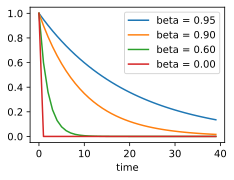

In [21]:
d2l.set_figsize()
betas = [0.95, 0.9, 0.6, 0]
for beta in betas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, beta ** x, label=f'beta = {beta:.2f}')
d2l.plt.xlabel('time')
d2l.plt.legend()

epoch 20, x1: -0.943467, x2: -0.000073


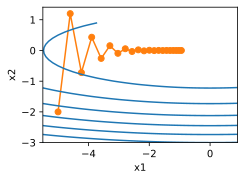

In [8]:
eta = 0.4
def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2
def gd_2d(x1, x2, s1, s2):
    return (x1 - eta * 0.2 * x1, x2 - eta * 4 * x2, 0, 0)

d2l.show_trace_2d(f_2d, d2l.train_2d(gd_2d))

在 x2 方向上优化很好，而 x1 方向上优化较差， 无法找到一个统一的学习率在这两个方向上具有一样好的效果。  
使用动量法解决上述问题   
$$ \begin{split}\begin{aligned}
\mathbf{v}_t &\leftarrow \beta \mathbf{v}_{t-1} + \mathbf{g}_{t, t-1}, \\
\mathbf{x}_t &\leftarrow \mathbf{x}_{t-1} - \eta_t \mathbf{v}_t.
\end{aligned}\end{split} $$

epoch 20, x1: 0.007188, x2: 0.002553


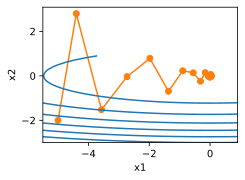

In [9]:
def momentum_2d(x1, x2, v1, v2):
    v1 = beta * v1 + 0.2 * x1  # 使用 beta 计算动量
    v2 = beta * v2 + 4 * x2
    return x1 - eta * v1, x2 - eta * v2, v1, v2

eta, beta = 0.6, 0.5
d2l.show_trace_2d(f_2d, d2l.train_2d(momentum_2d))

### 动量法实现  

In [10]:
def init_momentum_states(feature_dim):
    v_w = torch.zeros((feature_dim, 1))
    v_b = torch.zeros(1)
    return (v_w, v_b)

def sgd_momentum(params, states, hyperparams):
    for p, v in zip(params, states):
        with torch.no_grad():
            v[:] = hyperparams['momentum'] * v + p.grad
            p[:] -= hyperparams['lr'] * v
        p.grad.data.zero_()

loss: 0.245, 0.069 sec/epoch


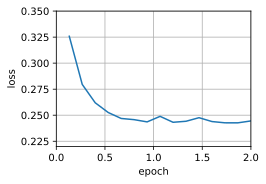

In [11]:
def train_momentum(lr, momentum, num_epochs=2):
    d2l.train_ch11(sgd_momentum, init_momentum_states(feature_dim),
                   {'lr': lr, 'momentum': momentum}, data_iter,
                   feature_dim, num_epochs)

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
train_momentum(0.02, 0.5)

将 $ \beta $ 调整为 0.9， 则之前梯度的影响约为 10， 因此适当缩小学习率， 否则会出现较强的波动。当学习降为 0.005 时效果更好

loss: 0.242, 0.052 sec/epoch


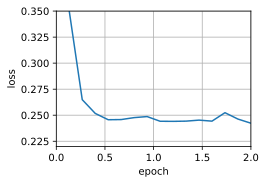

In [14]:
train_momentum(0.005, 0.9)

loss: 0.258, 0.060 sec/epoch


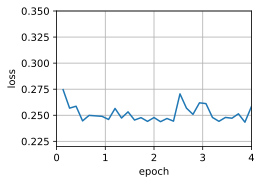

In [15]:
trainer = torch.optim.SGD
d2l.train_concise_ch11(trainer, {'lr': 0.005, 'momentum': 0.9}, data_iter)

## Adagrad

从自适应**调整学习率**的方式来理解**Adagrad**  
设想学习率随着迭代进行慢慢降低，可以达到更好的优化效果， 以 $ \mathcal{O}(t^{-\frac{1}{2}}) $ 的速率降低。  
$ \eta_i = \frac{\eta_0}{\sqrt{s(i, t) + c}} $  分母为关于迭代的函数  
使用梯度的平方来估算分母函数是比较有效的方式  
$$ \begin{split}\begin{aligned}
    \mathbf{g}_t & = \partial_{\mathbf{w}} l(y_t, f(\mathbf{x}_t, \mathbf{w})), \\
    \mathbf{s}_t & = \mathbf{s}_{t-1} + \mathbf{g}_t^2, \\
    \mathbf{w}_t & = \mathbf{w}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \cdot \mathbf{g}_t.
\end{aligned}\end{split} $$

epoch 20, x1: -2.382563, x2: -0.158591


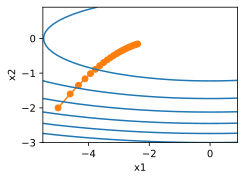

In [16]:
def adagrad_2d(x1, x2, s1, s2):
    eps = 1e-6
    g1, g2 = 0.2 * x1, 4 * x2
    s1 += g1 ** 2
    s2 += g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta = 0.4
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

由于梯度平方累积的较快，因此学习率衰减较快，需要放大初始学习率。 

epoch 20, x1: -0.002295, x2: -0.000000


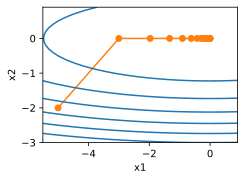

In [17]:
eta = 2
d2l.show_trace_2d(f_2d, d2l.train_2d(adagrad_2d))

### 实现

In [18]:
def init_adagrad_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def adagrad(params, states, hyperparams):
    eps = 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] += torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

与 Momentum 中的实验相比，我们使用更大的学习率来训练模型。

loss: 0.243, 0.059 sec/epoch


([0.012073993682861328,
  0.019177913665771484,
  0.026183128356933594,
  0.03348565101623535,
  0.04222559928894043,
  0.050408363342285156,
  0.05859804153442383,
  0.0653681755065918,
  0.07339143753051758,
  0.08088850975036621,
  0.08880305290222168,
  0.09559941291809082,
  0.10348153114318848,
  0.11101818084716797,
  0.11855006217956543],
 [0.26543548186620075,
  0.25362373717625936,
  0.24943293754259746,
  0.24571154201030732,
  0.24979716877142588,
  0.253144138276577,
  0.2441211588581403,
  0.24558122972647348,
  0.2437370657523473,
  0.2437046501636505,
  0.24596103282769521,
  0.2425013036330541,
  0.24432290736834208,
  0.24299598364035288,
  0.2434492538968722])

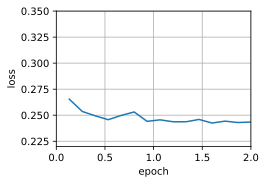

In [19]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adagrad, init_adagrad_states(feature_dim),
               {'lr': 0.1}, data_iter, feature_dim)

loss: 0.242, 0.057 sec/epoch


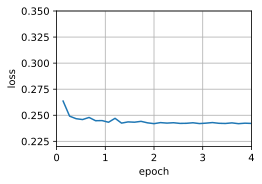

In [20]:
trainer = torch.optim.Adagrad
d2l.train_concise_ch11(trainer, {'lr': 0.1}, data_iter)

### 小结
* Adagrad 在每坐标基础上动态降低学习率  
* 它使用梯度的幅度作为调整速度的手段——梯度大的坐标用较小的学习率进行补偿。
* 计算精确的二阶导数在深度学习问题中通常不可行，因为存在内存和计算限制。梯度可以作为一个有用的代理。
* 如果优化问题具有相当不均匀的结构，Adagrad 可以帮助减轻扭曲。
* Adagrad 特别适用于稀疏特征，其中学习率需要更慢地降低不常出现的术语。
* 在深度学习问题中，Adagrad 有时在降低学习率方面过于激进。需要使用适当的手段修正。

## RMSProp  
由于 Adagrad 的学习率衰减过快，因此使用滑动平均来归一化 $ \mathbf{s}_t $ 值，防止其线性增加（$ \mathbf{s}_t = \mathbf{s}_{t-1} + \mathbf{g}_t^2 $）。
$$ \begin{split}\begin{aligned}
    \mathbf{s}_t & \leftarrow \gamma \mathbf{s}_{t-1} + (1 - \gamma) \mathbf{g}_t^2, \\
    \mathbf{x}_t & \leftarrow \mathbf{x}_{t-1} - \frac{\eta}{\sqrt{\mathbf{s}_t + \epsilon}} \odot \mathbf{g}_t.
\end{aligned}\end{split} $$  
将滑动平均展开，得如下公式，取得极限后可得其为加权和为 1 的求和。
$$ \begin{split}\begin{aligned}
\mathbf{s}_t & = (1 - \gamma) \mathbf{g}_t^2 + \gamma \mathbf{s}_{t-1} \\
& = (1 - \gamma) \left(\mathbf{g}_t^2 + \gamma \mathbf{g}_{t-1}^2 + \gamma^2 \mathbf{g}_{t-2} + \ldots, \right).
\end{aligned}\end{split} $$

Text(0.5, 0, 'time')

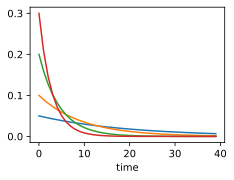

In [22]:
d2l.set_figsize()
gammas = [0.95, 0.9, 0.8, 0.7]
for gamma in gammas:
    x = torch.arange(40).detach().numpy()
    d2l.plt.plot(x, (1-gamma) * gamma ** x, label=f'gamma = {gamma:.2f}')
d2l.plt.xlabel('time')

gamma 越大表示所得结果越平均

epoch 20, x1: -0.010599, x2: 0.000000


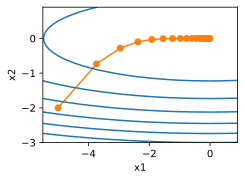

In [23]:
def rmsprop_2d(x1, x2, s1, s2):
    g1, g2, eps = 0.2 * x1, 4 * x2, 1e-6
    s1 = gamma * s1 + (1 - gamma) * g1 ** 2
    s2 = gamma * s2 + (1 - gamma) * g2 ** 2
    x1 -= eta / math.sqrt(s1 + eps) * g1
    x2 -= eta / math.sqrt(s2 + eps) * g2
    return x1, x2, s1, s2

def f_2d(x1, x2):
    return 0.1 * x1 ** 2 + 2 * x2 ** 2

eta, gamma = 0.4, 0.9
d2l.show_trace_2d(f_2d, d2l.train_2d(rmsprop_2d))

In [24]:
def init_rmsprop_states(feature_dim):
    s_w = torch.zeros((feature_dim, 1))
    s_b = torch.zeros(1)
    return (s_w, s_b)

def rmsprop(params, states, hyperparams):
    gamma, eps = hyperparams['gamma'], 1e-6
    for p, s in zip(params, states):
        with torch.no_grad():
            s[:] = gamma * s + (1 - gamma) * torch.square(p.grad)
            p[:] -= hyperparams['lr'] * p.grad / torch.sqrt(s + eps)
        p.grad.data.zero_()

loss: 0.245, 0.068 sec/epoch


([0.009990453720092773,
  0.016123056411743164,
  0.024593353271484375,
  0.033026695251464844,
  0.04361915588378906,
  0.05579638481140137,
  0.06821966171264648,
  0.07844185829162598,
  0.08558011054992676,
  0.09299039840698242,
  0.10045242309570312,
  0.10896444320678711,
  0.11796092987060547,
  0.12767601013183594,
  0.13605761528015137],
 [0.3517805176575979,
  0.29780790944894153,
  0.26849393542607625,
  0.2533188171386719,
  0.2489040363629659,
  0.24942492761214574,
  0.2448663357893626,
  0.24778558739026388,
  0.24571084866921106,
  0.24452621658643087,
  0.24308178357283275,
  0.2424908559322357,
  0.24286061787605287,
  0.24323492753505707,
  0.24485870371262233])

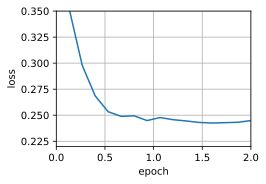

In [25]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(rmsprop, init_rmsprop_states(feature_dim),
               {'lr': 0.01, 'gamma': 0.9}, data_iter, feature_dim)  # gamma=0.9 表示聚合过去 10 个梯度后的平均值

## Adadelta  
该方法不需要 **学习率**， 通过参数的变化率及梯度的二阶矩估计自适应调整梯度大小。    https://d2l.ai/chapter_optimization/adadelta.html
$$ \begin{aligned}
    \mathbf{s}_t & = \rho \mathbf{s}_{t-1} + (1 - \rho) \mathbf{g}_t^2.
\end{aligned}$$
$$\begin{split}\begin{aligned}
    \mathbf{x}_t  & = \mathbf{x}_{t-1} - \mathbf{g}_t'. \\
\end{aligned}\end{split}$$
$$\begin{split}\begin{aligned}
    \mathbf{g}_t' & = \frac{\sqrt{\Delta\mathbf{x}_{t-1} + \epsilon}}{\sqrt{{\mathbf{s}_t + \epsilon}}} \odot \mathbf{g}_t, \\
\end{aligned}\end{split}$$
$$\begin{aligned}
    \Delta \mathbf{x}_t & = \rho \Delta\mathbf{x}_{t-1} + (1 - \rho) {\mathbf{g}_t'}^2,
\end{aligned}$$

In [26]:
def init_adadelta_states(feature_dim):
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    delta_w, delta_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((s_w, delta_w), (s_b, delta_b))

def adadelta(params, states, hyperparams):
    rho, eps = hyperparams['rho'], 1e-5
    for p, (s, delta) in zip(params, states):
        with torch.no_grad():
            # In-place updates via [:]
            s[:] = rho * s + (1 - rho) * torch.square(p.grad)
            g = (torch.sqrt(delta + eps) / torch.sqrt(s + eps)) * p.grad
            p[:] -= g
            delta[:] = rho * delta + (1 - rho) * g * g
        p.grad.data.zero_()

loss: 0.244, 0.089 sec/epoch


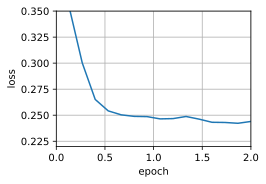

In [27]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adadelta, init_adadelta_states(feature_dim),
               {'rho': 0.9}, data_iter, feature_dim)

loss: 0.243, 0.074 sec/epoch


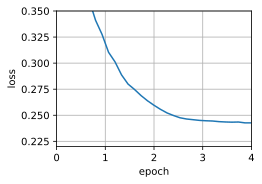

In [28]:
trainer = torch.optim.Adadelta
d2l.train_concise_ch11(trainer, {'rho': 0.9}, data_iter)

## Adam 

结合以上方法，通过  
1.计算梯度的指数滑动平均 及 二阶矩估算，2. 按照迭代轮次缩放（使用偏差校正来调整估计动量和二阶矩缓慢启动的问题，即在算法开始阶段适当放大计算的值）， 3. 计算最终该轮迭代参数的更新量。  
1. 计算梯度的指数滑动平均 及 二阶矩估算  
$$  \begin{split}\begin{aligned}
    \mathbf{v}_t & \leftarrow \beta_1 \mathbf{v}_{t-1} + (1 - \beta_1) \mathbf{g}_t, \\
    \mathbf{s}_t & \leftarrow \beta_2 \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2.
\end{aligned}\end{split} $$
2. 按照迭代轮次缩放  
$$ \hat{\mathbf{v}}_t = \frac{\mathbf{v}_t}{1 - \beta_1^t} \textrm{ and } \hat{\mathbf{s}}_t = \frac{\mathbf{s}_t}{1 - \beta_2^t}. $$  
3. 计算最终该轮迭代参数的更新量
$ \mathbf{g}_t' = \frac{\eta \hat{\mathbf{v}}_t}{\sqrt{\hat{\mathbf{s}}_t} + \epsilon}. $  
4. $ \mathbf{x}_t \leftarrow \mathbf{x}_{t-1} - \mathbf{g}_t'. $

### 实现

In [29]:
def init_adam_states(feature_dim):
    v_w, v_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    s_w, s_b = torch.zeros((feature_dim, 1)), torch.zeros(1)
    return ((v_w, s_w), (v_b, s_b))

def adam(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-6
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = beta2 * s + (1 - beta2) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

loss: 0.244, 0.083 sec/epoch


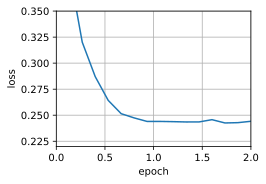

In [30]:
data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(adam, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim)

### Yogi 
Adam 算法的一个问题是，即使在凸设置下，当 st 的第二矩估计爆炸时，它也可能无法收敛。因此通过改进二阶矩的更新幅度来优化二阶矩的幅值，优化收敛性  
原始 $ \mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \left(\mathbf{g}_t^2 - \mathbf{s}_{t-1}\right). $   
修改为 $ \mathbf{s}_t \leftarrow \mathbf{s}_{t-1} + (1 - \beta_2) \mathbf{g}_t^2 \odot \mathop{\textrm{sgn}}(\mathbf{g}_t^2 - \mathbf{s}_{t-1}). $

loss: 0.250, 0.076 sec/epoch


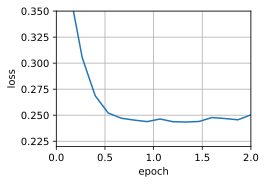

In [31]:
def yogi(params, states, hyperparams):
    beta1, beta2, eps = 0.9, 0.999, 1e-3
    for p, (v, s) in zip(params, states):
        with torch.no_grad():
            v[:] = beta1 * v + (1 - beta1) * p.grad
            s[:] = s + (1 - beta2) * torch.sign(
                torch.square(p.grad) - s) * torch.square(p.grad)
            v_bias_corr = v / (1 - beta1 ** hyperparams['t'])
            s_bias_corr = s / (1 - beta2 ** hyperparams['t'])
            p[:] -= hyperparams['lr'] * v_bias_corr / (torch.sqrt(s_bias_corr)
                                                       + eps)
        p.grad.data.zero_()
    hyperparams['t'] += 1

data_iter, feature_dim = d2l.get_data_ch11(batch_size=10)
d2l.train_ch11(yogi, init_adam_states(feature_dim),
               {'lr': 0.01, 't': 1}, data_iter, feature_dim)

对于具有**显著差异**的梯度，我们可能会遇到收敛问题。这些问题可以通过使用更大的 minibatch 或切换到对 st 的改进估计来解决。Yogi 提供了这样的替代方案

## Learning Rate Scheduling

In [6]:
from torch.optim import lr_scheduler

def net_fn():
    model = nn.Sequential(
        nn.Conv2d(1, 6, kernel_size=5, padding=2), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, kernel_size=5), nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16 * 5 * 5, 120), nn.ReLU(),
        nn.Linear(120, 84), nn.ReLU(),
        nn.Linear(84, 10))

    return model

loss = nn.CrossEntropyLoss()
device = d2l.try_gpu()

batch_size = 64
train_iter, test_iter = d2l.load_data_fashion_mnist(batch_size=batch_size)

def train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
          scheduler=None):
    net.to(device)
    animator = d2l.Animator(xlabel='epoch', xlim=[0, num_epochs],
                            legend=['train loss', 'train acc', 'test acc'])

    for epoch in range(num_epochs):
        metric = d2l.Accumulator(3)  # train_loss, train_acc, num_examples
        for i, (X, y) in enumerate(train_iter):
            net.train()
            trainer.zero_grad()
            X, y = X.to(device), y.to(device)
            y_hat = net(X)
            l = loss(y_hat, y)
            l.backward()
            trainer.step()
            with torch.no_grad():
                metric.add(l * X.shape[0], d2l.accuracy(y_hat, y), X.shape[0])
            train_loss = metric[0] / metric[2]
            train_acc = metric[1] / metric[2]
            if (i + 1) % 50 == 0:
                animator.add(epoch + i / len(train_iter),
                             (train_loss, train_acc, None))

        test_acc = d2l.evaluate_accuracy_gpu(net, test_iter)
        animator.add(epoch+1, (None, None, test_acc))

        if scheduler:
            if scheduler.__module__ == lr_scheduler.__name__:
                # Using PyTorch In-Built scheduler
                scheduler.step()
            else:
                # Using custom defined scheduler
                for param_group in trainer.param_groups:
                    param_group['lr'] = scheduler(epoch)

    print(f'train loss {train_loss:.3f}, train acc {train_acc:.3f}, '
          f'test acc {test_acc:.3f}')

train loss 0.140, train acc 0.946, test acc 0.890


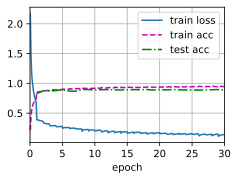

In [3]:
lr, num_epochs = 0.3, 30
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device)

通过参数显式设置优化器中的学习率

In [8]:
trainer.param_groups[0]["lr"]
lr_scheduler.__name__

'torch.optim.lr_scheduler'

In [9]:
#  设置
class SquareRootScheduler:
    def __init__(self, lr=0.1):
        self.lr = lr

    def __call__(self, num_update):
        return self.lr * pow(num_update + 1.0, -0.5)

train loss 0.164, train acc 0.939, test acc 0.897


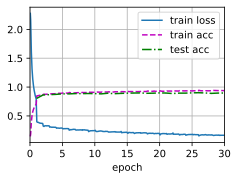

In [11]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
scheduler = SquareRootScheduler(lr=0.1)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

### 调度器种类

#### 指数衰减

$ \eta_{t+1} \leftarrow \mathop{\mathrm{max}}(\eta_{\mathrm{min}}, \eta_t \cdot \alpha)~for~\alpha \in (0, 1) $

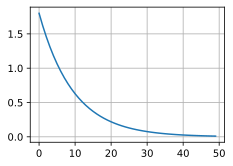

In [12]:
class FactorScheduler:
    def __init__(self, factor=1, stop_factor_lr=1e-7, base_lr=0.1):
        self.factor = factor
        self.stop_factor_lr = stop_factor_lr
        self.base_lr = base_lr

    def __call__(self, num_update):
        self.base_lr = max(self.stop_factor_lr, self.base_lr * self.factor)
        return self.base_lr

scheduler = FactorScheduler(factor=0.9, stop_factor_lr=1e-2, base_lr=2.0)
d2l.plot(torch.arange(50), [scheduler(t) for t in range(50)])

#### 分段衰减

$ \eta_{t+1} \leftarrow \eta_t \cdot \alpha $  在特定时间步时调整学习率

In [20]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.5)
scheduler = lr_scheduler.MultiStepLR(trainer, milestones=[15, 30], gamma=0.5)

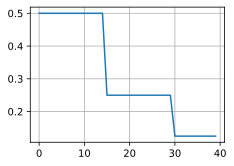

In [21]:
def get_lr(trainer, scheduler):
    lr = scheduler.get_last_lr()[0]
    trainer.step()
    scheduler.step()
    return lr

d2l.plot(torch.arange(40), [get_lr(trainer, scheduler)
                                  for t in range(40)])

#### 余弦 cos 衰减
该调度器以余弦的趋势衰减学习率，某些情况在优化的开始及结束具有小的学习率会有比较好的效果  
通常在计算机视觉中会有较好的表现  

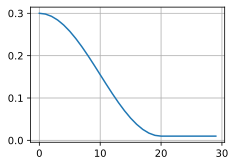

In [23]:
class CosineScheduler:
    def __init__(self, max_update, base_lr=0.01, final_lr=0,
               warmup_steps=0, warmup_begin_lr=0):
        self.base_lr_orig = base_lr
        self.max_update = max_update
        self.final_lr = final_lr
        self.warmup_steps = warmup_steps
        self.warmup_begin_lr = warmup_begin_lr
        self.max_steps = self.max_update - self.warmup_steps

    def get_warmup_lr(self, epoch):  # warm_up 阶段
        increase = (self.base_lr_orig - self.warmup_begin_lr) \
                       * float(epoch) / float(self.warmup_steps)
        return self.warmup_begin_lr + increase

    def __call__(self, epoch):
        if epoch < self.warmup_steps:
            return self.get_warmup_lr(epoch)
        if epoch <= self.max_update:
            self.base_lr = self.final_lr + (
                self.base_lr_orig - self.final_lr) * (1 + math.cos(
                math.pi * (epoch - self.warmup_steps) / self.max_steps)) / 2
        return self.base_lr

scheduler = CosineScheduler(max_update=20, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.079, train acc 0.972, test acc 0.906


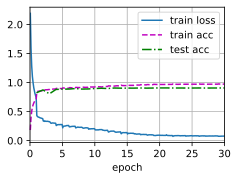

In [24]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

#### Warm up

在某些情况下，初始化参数不足以保证得到良好的解。这尤其是一些高级网络设计的问题，可能会导致不稳定的优化问题。  
我们可以通过选择足够小的学习率来防止初始阶段的发散。不幸的是，这意味着进展缓慢。相反，初始阶段的学习率过大会导致发散。  
一个解决这个困境的相对简单的方法是在一个预热期间将学习率增加到其初始最大值，并在优化过程结束时降低该率。

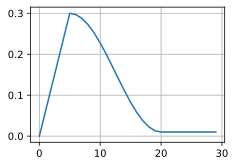

In [25]:
scheduler = CosineScheduler(20, warmup_steps=5, base_lr=0.3, final_lr=0.01)
d2l.plot(torch.arange(num_epochs), [scheduler(t) for t in range(num_epochs)])

train loss 0.117, train acc 0.957, test acc 0.904


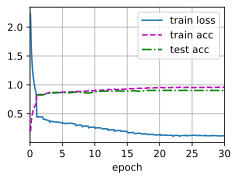

In [26]:
net = net_fn()
trainer = torch.optim.SGD(net.parameters(), lr=0.3)
train(net, train_iter, test_iter, num_epochs, loss, trainer, device,
      scheduler)

## QA
Q： 在模型训练时，如果训练集中数据比较类似，batch_size过大会降低模型效果吗？  
A： batch size 过大可能会对模型效果产生不利影响：  
1. 梯度估计的多样性降低：较大的 batch size 会使得每次迭代中的梯度估计更加接近于训练集的全局平均梯度，导致更新的方向缺乏多样性。对于相似的数据，这会导致模型在局部最优中陷得更深，难以跳出，降低了模型的泛化能力。
2. 欠拟合风险：如果 batch size 过大，模型在训练过程中可能会更快收敛，但这种快速收敛可能是表面的，训练过程中的数据变动不足，模型在相似的数据上过早结束训练，最终可能导致欠拟合。
3. 局部极值点问题：较大的 batch size 可能会导致模型陷入局部极值点，而不是全局最优。较小的 batch size 则由于梯度的随机波动，有助于跳出局部极值点，找到更好的解。